# 3D реконструкция сцены

## Установка

```bash
git clone https://github.com/colmap/colmap

sudo apt-get install \
    git \
    cmake \
    ninja-build \
    build-essential \
    libboost-program-options-dev \
    libboost-graph-dev \
    libboost-system-dev \
    libeigen3-dev \
    libfreeimage-dev \
    libmetis-dev \
    libgoogle-glog-dev \
    libgtest-dev \
    libgmock-dev \
    libsqlite3-dev \
    libglew-dev \
    qtbase5-dev \
    libqt5opengl5-dev \
    libcgal-dev \
    libceres-dev \
    libcurl4-openssl-dev \
    libmkl-full-dev

# -------------------------
# CUDA
sudo apt-get install -y \
    nvidia-cuda-toolkit \
    nvidia-cuda-toolkit-gcc
# -------------------------

git clone https://github.com/colmap/colmap.git
cd colmap
mkdir build
cd build
cmake .. -GNinja -DCMAKE_CUDA_ARCHITECTURES=120 -DBLA_VENDOR=Intel10_64lp
ninja
sudo ninja install

colmap -h
colmap gui

## Ключевые концепции COLMAP

### 1. Введение понятий «риги» и «фреймы»

Начиная с версии **COLMAP 3.12** введены два фундаментальных понятия:
* **риги** (*rigs*);
* **фреймы** (*frames*).

Их назначение:
* моделирование платформ с **множеством датчиков**;
* обработка **панорамных изображений с обзором 360°**;
* структурированная организация датчиков и их измерений;
* гибкая калибровка и объединение разнородных типов данных.

## 2. Датчики и измерения

### Определение

**Датчик** (*sensor*) — устройство, собирающее данные об окружающей среде и формирующее измерения в конкретные моменты времени (*timestamps*).

### Типы датчиков

1. **Камера** (*camera*) — наиболее распространённый тип; измерения представляют собой изображения.
2. **IMU** (инерционные измерительные устройства) — регистрируют:
   * ускорение;
   * угловую скорость.
3. **Приёмники GNSS** — предоставляют данные об абсолютном местоположении.

### Текущая поддержка в COLMAP

На данный момент COLMAP поддерживает **только камеры и их изображения**. Однако архитектура предусматривает будущую интеграцию:
* IMU;
* GNSS;
* других типов датчиков для мультимодального объединения данных.

## 3. Риги

### Определение

**Риг** (*rig*) — платформа, объединяющая несколько датчиков с **фиксированными взаимными положениями** (позами). Обеспечивает **синхронный и согласованный** сбор данных с нескольких датчиков.

### Примеры ригов

* стереокамеры;
* носимые устройства AR/VR;
* комплексы датчиков для автономных транспортных средств;
* **виртуальные риги** (например, набор виртуальных камер для создания панорам 360°).

### Правила ассоциации в COLMAP

1. Каждый датчик **однозначно** привязан ровно к **одному ригу**.
2. Каждый риг имеет **один опорный датчик**, определяющий его начало координат.

### Примеры конфигурации

* **Стереокамера:**
   * одна камера — опорный датчик (поза `sensor_from_rig` — единичная);
   * вторая камера — поза задаётся относительно опорной.
* **Одиночная камера:**
   * сама камера является опорным датчиком для своего рига.

## 4. Фреймы

### Определение

**Фрейм** (*frame*) — снимок рига в **конкретный момент времени**, содержащий измерения от одного или нескольких датчиков внутри этого рига.

### Особенности

* Может включать данные **от всех датчиков** рига или **только от части** (в зависимости от доступности).
* Позволяет связывать многосенсорные данные в **конкретные моменты времени**.

### Пример

В стереокамере, записывающей видео:
* каждый фрейм соответствует **двум изображениям** (по одному от каждой камеры);
* оба изображения сняты **в один и тот же момент времени**.

## Структура базы данных COLMAP

### 1. Общая информация

COLMAP хранит все извлечённые данные в **едином файле SQLite‑базы**. Доступ к базе возможен следующими способами:
* через графический интерфейс (GUI) COLMAP;
* посредством C++ API (`src/colmap/scene/database.h`);
* с использованием Python‑библиотеки `pycolmap`.

### 2. Список таблиц базы данных

База данных содержит следующие таблицы:

* `rigs` — описание ригов (платформ с датчиками);
* `cameras` — параметры камер;
* `frames` — фреймы (снимки рига в конкретный момент времени);
* `images` — метаданные изображений;
* `keypoints` — ключевые точки на изображениях;
* `descriptors` — дескрипторы ключевых точек;
* `matches` — соответствия между ключевыми точками;
* `two_view_geometries` — геометрическая информация о парах снимков.

### 3. Связи между таблицами


#### 3.1. Риги и датчики (камеры)

* **Тип связи:** 1 к N (один риг — множество датчиков).
* В каждом риге выделяется **опорный датчик**, определяющий начало координат рига.
* Каждый датчик может принадлежать **только одному ригу**.

#### 3.2. Риги и фреймы

* **Тип связи:** 1 к N (один риг — множество фреймов).
* Фрейм представляет собой **конкретный момент съёмки** рига.
* В фрейме могут присутствовать данные от всех или части датчиков рига.


#### 3.3. Камеры и изображения

* **Тип связи:** 1 к N (одна камера — множество изображений).
* **Внутренние параметры** камеры (фокусное расстояние, главная точка, дисторсия) **общи для всех её изображений**.
* Каждое изображение имеет **отдельные внешние параметры** (положение и ориентация камеры в момент съёмки).

### 4. Детализация таблиц


#### 4.1. Таблица `cameras` (камеры)

* Внутренние параметры хранятся как **бинарный блок типа `float64`**.
* Порядок параметров определён в `src/colmap/sensor/models.h`.
* В базе сохраняются только камеры, на которые есть ссылки из таблицы `images`.


#### 4.2. Таблица `images` (изображения)

* Столбец `name` содержит **относительный путь** к файлу изображения.
* База и папка с изображениями могут быть перемещены при сохранении **относительной структуры путей**.
* Идентификаторы `image_id` и `camera_id` должны быть **положительными** (`> 0`).


#### 4.3. Таблица `keypoints` (ключевые точки)

* Хранятся как **бинарный блок типа `float32`**.
* Первые два столбца: координаты **X** и **Y** точки на изображении.
* Начало координат: верхний левый угол изображения (`0, 0`).
* Центр пикселя в углу: `(0.5, 0.5)`.
* При наличии 4 столбцов:
  * 3‑й столбец — масштаб;
  * 4‑й столбец — ориентация (по стандарту SIFT).
* При наличии 6 столбцов: последние 4 описывают **аффинную форму** точки (см. `src/feature/types.h`).

#### 4.4. Таблица `descriptors` (дескрипторы)

* Хранятся как **бинарный блок типа `uint8`**.
* Каждая строка соответствует «отпечатку» внешности ключевой точки из таблицы `keypoints`.
* Поддерживаются только **128‑мерные дескрипторы** (`cols = 128`).

#### 4.5. Таблица `matches` (соответствия)

* Содержит пары индексов ключевых точек между двумя изображениями.
* Бинарный блок: **матрица типа `uint32`** (2 столбца):
  * левый столбец — индексы точек из `image_id1`;
  * правый столбец — индексы точек из `image_id2`.
* `cols = 2`; `rows` — число соответствий.


#### 4.6. Таблица `two_view_geometries` (геометрия пар снимков)

* Хранит матрицы:
  * **F** — фундаментальная матрица;
  * **E** — эссенциальная матрица;
  * **H** — гомографическая матрица.
* Матрицы представлены как **3 × 3 `float64`** в построчном формате.
* Столбец `config` описывает тип геометрии (см. `src/estimators/two_view_geometry.h`).

### 5. Механизм идентификаторов пар снимков (`pair_id`)

Для эффективного поиска соответствий между снимками используется **уникальный идентификатор пары изображений** — `pair_id`.

#### 5.1. Генерация `pair_id`

```cpp
def image_ids_to_pair_id(image_id1, image_id2):
    if image_id1 > image_id2:
        return 2147483647 * image_id2 + image_id1
    else:
        return 2147483647 * image_id1 + image_id2
```

#### 5.2. Восстановление `image_id` из `pair_id`

```cpp
def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % 2147483647
    image_id1 = (pair_id - image_id2) / 2147483647
    return image_id1, image_id2
```

#### 5.3. Ограничения

* Максимальное число изображений в базе: **2 147 483 647** (предел 32‑битного целого).
* `image_id` должен быть **меньше** указанного предела.


### 6. Заключение

База данных COLMAP представляет собой **структурированное хранилище**, обеспечивающее:
* управление параметрами камер и ригов;
* хранение изображений и их метаданных;
* обработку ключевых точек и их дескрипторов;
* установление соответствий между точками на разных снимках;
* расчёт геометрической информации для 3D‑реконструкции.

Данная архитектура позволяет COLMAP автоматически строить 3D‑модели на основе фотоматериалов, полученных с различных устройств и в разное время.

# Поддержка ригов в COLMAP

Современные версии **COLMAP** поддерживают моделирование **риг-систем** (*sensor rigs*) в процессе реконструкции.
Риг рассматривается как совокупность сенсоров с фиксированными взаимными положениями, где один из них выбран **опорным датчиком**, определяющим начало координат рига.
**Фрейм** в этом контексте представляет собой конкретное состояние рига в момент времени — набор измерений всех или части сенсоров, активных одновременно.

Типичный пример — **стереокамера**: одна камера выступает опорным датчиком с единичной позой `sensor_from_rig`, а вторая имеет положение, заданное относительно первой. Каждый фрейм в таком случае включает два изображения, полученных одновременно обоими датчиками.

### Рабочий процесс настройки рига

#### 1. Подготовка структуры данных

По умолчанию стандартный конвейер COLMAP рассматривает каждую камеру как отдельный риг, где каждый фрейм содержит одно изображение.
Чтобы задать реальные риги, необходимо организовать изображения в иерархическую структуру каталогов, отражающую состав установок:

```
rig1/
    camera1/
        image0001.jpg
        image0002.jpg
        ...
    camera2/
        image0001.jpg   # соответствует тому же фрейму, что и camera1/image0001.jpg
        image0002.jpg
        ...
rig2/
    camera1/
        ...
```

Главное условие: **файлы, соответствующие одному фрейму, должны иметь одинаковые имена** во всех папках.

---

#### 2. Извлечение признаков

Первый шаг — извлечение дескрипторов и ключевых точек для всех изображений.
Для этого используется команда:

```bash
colmap feature_extractor \
    --image_path $DATASET_PATH/images \
    --database_path $DATASET_PATH/database.db \
    --ImageReader.single_camera_per_folder 1
```

Флаг `--ImageReader.single_camera_per_folder 1` сообщает COLMAP, что каждая папка соответствует отдельной камере.
На этом этапе в базе данных создаются отдельные риги и фреймы для каждой камеры и изображения.

---

#### 3. Конфигурирование ригов

Далее необходимо скорректировать взаимосвязи между камерами, зафиксировав структуру рига.
Это выполняется командой:

```bash
colmap rig_configurator \
    --database_path $DATASET_PATH/database.db \
    --rig_config_path $DATASET_PATH/rig_config.json
```

Пример конфигурационного файла `rig_config.json`, если взаимное положение сенсоров известно заранее:

```json
[
  {
    "cameras": [
      {
        "image_prefix": "rig1/camera1/",
        "ref_sensor": true
      },
      {
        "image_prefix": "rig1/camera2/",
        "cam_from_rig_rotation": [0.7071, 0.0, 0.7071, 0.0],
        "cam_from_rig_translation": [0, 0, 0]
      }
    ]
  }
]
```

Этот файл определяет структуру рига и обновляет соответствующие записи в базе данных.
При наличии известных параметров калибровки можно добавить поля `camera_model_name` и `camera_params`.

Для более детальной настройки допускается использование Python-интерфейса **pycolmap**, где функции `apply_rig_config` или прямое добавление ригов и фреймов обеспечивают максимальную гибкость.

---

#### 4. Сопоставление признаков и реконструкция

После задания конфигурации выполняется стандартное сопоставление признаков.
Важно настроить риги **до** последовательного сопоставления (`sequential_matcher`), поскольку соседние фреймы автоматически сравниваются друг с другом.

Затем запускается реконструкция сцены с сохранением фиксированных относительных поз в риге:

```bash
colmap mapper \
    --Mapper.ba_refine_sensor_from_rig 0
```


### Неизвестные относительные позы сенсоров

Если взаимное расположение камер в риге **неизвестно**, можно применить двухэтапную стратегию.

1. **Первичная реконструкция без ригов.**

   Все камеры рассматриваются как отдельные установки. Главное — чтобы каждая камера имела хотя бы одно зарегистрированное изображение, совпадающее по фрейму с изображением опорной камеры.

2. **Оценка структуры рига.**

   Используется тот же инструмент `rig_configurator`, но без указания `cam_from_rig_rotation` и `cam_from_rig_translation`.
   В этом случае COLMAP вычисляет средние относительные позы между сенсорами на основе уже реконструированных изображений:

   ```bash
   colmap rig_configurator \
       --database_path $DATASET_PATH/database.db \
       --input_path $DATASET_PATH/sparse-model-without-rigs-and-frames \
       --rig_config_path $DATASET_PATH/rig_config.json \
       --output_path $DATASET_PATH/sparse-model-with-rigs-and-frames
   ```

Далее можно выполнить **bundle adjustment** для уточнения параметров:

```bash
colmap bundle_adjuster \
    --input_path $DATASET_PATH/sparse-model-with-rigs-and-frames \
    --output_path $DATASET_PATH/bundled-sparse-model-with-rigs-and-frames
```

Либо начать реконструкцию заново, уже с учётом риговых ограничений.

### Пример реконструкции (ETH3D Rig Dataset)

В качестве демонстрации рассмотрим реконструкцию набора **ETH3D Terrains Rig**:

```bash
wget https://www.eth3d.net/data/terrains_rig_undistorted.7z
7zz x terrains_rig_undistorted.7z
```

**1. Извлечение признаков:**

```bash
colmap feature_extractor \
    --database_path terrains/database.db \
    --image_path terrains/images \
    --ImageReader.single_camera_per_folder 1
```

**2. Настройка рига с использованием готовой реконструкции (groundtruth):**

```bash
colmap rig_configurator \
    --database_path terrains/database.db \
    --rig_config_path terrains/rig_config.json \
    --input_path terrains/rig_calibration_undistorted
```

Файл конфигурации:

```json
[
  {
    "cameras": [
      { "image_prefix": "images_rig_cam4_undistorted/", "ref_sensor": true },
      { "image_prefix": "images_rig_cam5_undistorted/" },
      { "image_prefix": "images_rig_cam6_undistorted/" },
      { "image_prefix": "images_rig_cam7_undistorted/" }
    ]
  }
]
```

Поскольку указана готовая реконструкция, сенсорные позы не задаются вручную — они вычисляются автоматически на основе имеющихся данных.

**3. Сопоставление последовательных кадров:**

```bash
colmap sequential_matcher --database_path terrains/database.db
```

**4. Реконструкция сцены:**

```bash
mkdir -p terrains/sparse
colmap mapper \
    --database_path terrains/database.db \
    --Mapper.ba_refine_sensor_from_rig 0 \
    --Mapper.ba_refine_focal_length 0 \
    --Mapper.ba_refine_extra_params 0 \
    --image_path terrains/images \
    --output_path terrains/sparse
```

# Форматы выходных данных в COLMAP

COLMAP сохраняет результаты реконструкции в собственных **бинарных** и **текстовых** форматах.
Бинарные файлы читаются быстрее и используются по умолчанию, текстовые — удобны для анализа человеком.
Все бинарные данные хранятся в формате **little endian**, что совместимо с большинством современных процессоров.

### Индексы и идентификаторы

В COLMAP различаются:

* `*_idx` — **индексы**: упорядоченные, начинаются с нуля;
* `*_id` — **идентификаторы**: уникальные, но не обязательно последовательные.

Например, `POINT3D_ID` может иметь пропуски, поскольку некоторые точки отбрасываются при фильтрации.

### Разреженная реконструкция (Sparse Model)

Каждая разреженная модель хранится в папке, содержащей несколько файлов:
`rigs`, `cameras`, `frames`, `images`, `points3D`.
Форматы — `.bin` (бинарный) и `.txt` (текстовый). Если оба присутствуют, COLMAP загружает бинарный.

В старых версиях риги и фреймы отсутствовали — теперь они добавлены, но система остаётся обратно совместимой.

**Экспорт и импорт:**

* В GUI: *File → Export model* или *File → Export model as text*;
* CLI: утилита `model_converter`.

Существуют скрипты для чтения моделей на **Python** (`scripts/python/read_write_model.py`) и **Matlab** (`scripts/matlab/read_model.m`).

### Формат файлов

**`rigs.txt`** — описание ригов и сенсоров.
Пример:

```py
# Rig calib list with one line of data per calib:
#   RIG_ID, NUM_SENSORS, REF_SENSOR_TYPE, REF_SENSOR_ID, SENSORS[] as (SENSOR_TYPE, SENSOR_ID, HAS_POSE, [QW, QX, QY, QZ, TX, TY, TZ])
# Number of rigs: 1
1 2 CAMERA 1 CAMERA 2 1 -0.9999701516465348 -0.0011120266840749639 -0.0075347911527510894 0.0012985125893421306 -0.19316906391350164 0.00085222218993398979 0.0070758955539026785
2 1 CAMERA 3
```

Первый риг содержит две камеры, второй — одну.

**`cameras.txt`** — параметры калибровки:

```py
# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: 3
1 SIMPLE_PINHOLE 3072 2304 2559.81 1536 1152
2 PINHOLE 3072 2304 2560.56 2560.56 1536 1152
3 SIMPLE_RADIAL 3072 2304 2559.69 1536 1152 -0.0218531
```

Разные камеры могут использовать разные модели дисторсии и делить общие внутренние параметры.

**`frames.txt`** — состояние рига в момент съёмки:

```py
# Frame list with one line of data per frame:
#   FRAME_ID, RIG_ID, RIG_FROM_WORLD[QW, QX, QY, QZ, TX, TY, TZ], NUM_DATA_IDS, DATA_IDS[] as (SENSOR_TYPE, SENSOR_ID, DATA_ID)
# Number of frames: 151
1 1 0.99801363919752195 0.040985139360073107 0.041890917712361225 -0.023111584553400576 -5.2666546897987896 -0.17120007823690631 0.12300519697527648 2 CAMERA 1 1 CAMERA 2 2
2 2 0.99816472047267968 0.037605501383281774 0.043101511724657163 -0.019881568259519072 -5.1956060695789192 -0.20794508616745555 0.14967533910764824 1 CAMERA 3 3
```

**`images.txt`** — позы камер и ключевые точки:

```py
# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: 2, mean observations per image: 2
1 0.851773 0.0165051 0.503764 -0.142941 -0.737434 1.02973 3.74354 1 P1180141.JPG
2362.39 248.498 58396 1784.7 268.254 59027 1784.7 268.254 -1
2 0.851773 0.0165051 0.503764 -0.142941 -0.737434 1.02973 3.74354 1 P1180142.JPG
1190.83 663.957 23056 1258.77 640.354 59070
```

Позы заданы как преобразование из мировой системы координат в систему камеры (`world_to_camera`).
После строки с позой следует список 2D-точек и ID наблюдаемых 3D-точек.
Координаты заданы в пикселях, оси камеры: **X — вправо**, **Y — вниз**, **Z — вперёд**.

**`points3D.txt`** — координаты, цвет и ошибка проекции для каждой 3D-точки:

```py
# 3D point list with one line of data per point:
#   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
# Number of points: 3, mean track length: 3.3334
63390 1.67241 0.292931 0.609726 115 121 122 1.33927 16 6542 15 7345 6 6714 14 7227
63376 2.01848 0.108877 -0.0260841 102 209 250 1.73449 16 6519 15 7322 14 7212 8 3991
63371 1.71102 0.28566 0.53475 245 251 249 0.612829 118 4140 117 4473
```

Поле `ERROR` — средняя ошибка проекции (в пикселях).

### Плотная реконструкция (Dense Model)


Папка плотной реконструкции имеет типовую структуру:

```py
+── images/              # недисторированные снимки
+── sparse/              # результат SfM
+── stereo/              # результаты MVS
│   ├── depth_maps/      # карты глубины
│   ├── normal_maps/     # карты нормалей
│   └── consistency_graphs/
+── fused.ply            # плотное облако точек
+── meshed-poisson.ply   # сетка Poisson
+── meshed-delaunay.ply  # сетка Delaunay
```

Файлы `run-colmap-geometric.sh` и `run-colmap-photometric.sh` содержат примеры команд для запуска MVS.

### Карты глубины, нормалей и графы согласованности

* **Depth maps** и **Normal maps** — бинарные файлы с заголовком (`width&height&channels&`) и последующими данными `float32` в порядке строк.

  * Каналы: `1` для глубины, `3` для нормалей.
  * Читаются через Python (`scripts/python/read_dense.py`) или Matlab.

* **Consistency graphs** — указывают, с какими изображениями каждый пиксель согласован.

  Хранят пары `<row><col><N><image_idx1>...<image_idxN>` в бинарной части.

# Полный процесс реконструкции в COLMAP

# Введение

COLMAP — это программный комплекс для трёхмерной реконструкции сцен по множеству изображений.
Он объединяет два основных этапа: **Structure-from-Motion (SfM)** и **Multi-View Stereo (MVS)**,
и позволяет получить как разрежённую, так и плотную 3D-модель без необходимости ручного вмешательства в вычислительный процесс.

COLMAP спроектирован так, чтобы с ним можно было работать **на разных уровнях глубины**:
начинающий пользователь способен выполнить реконструкцию буквально за несколько шагов,
а опытный исследователь — получить полный контроль над параметрами, калибровками и алгоритмами.

По умолчанию программа использует **оптимальный баланс между качеством, скоростью и устойчивостью**.
Изменять параметры обычно не требуется: стандартные настройки подходят для большинства задач.
Если же нужно адаптировать поведение под конкретный сценарий (например, крупные объекты, видео-последовательности, или панорамную съёмку),
можно выбрать **Extras → Set options for … data** в меню интерфейса.
При сомнениях рекомендуется оставлять значения по умолчанию.
Расширенная документация всех параметров доступна непосредственно в исходном коде COLMAP.


COLMAP предоставляет два основных режима работы:

1. **Автоматический режим** — весь процесс (SfM + MVS) выполняется одной командой в GUI;
2. **Ручной (пошаговый) режим** — пользователь управляет каждым этапом отдельно.

Обе схемы основаны на одной архитектуре, но второй вариант позволяет лучше контролировать параметры и понимать, что именно делает каждая стадия.

## 1. Автоматическая реконструкция

Чтобы быстро получить результат, достаточно:

1. Запустить графический интерфейс (COLMAP GUI);
2. Выбрать пункт меню **Reconstruction → Automatic Reconstruction**;
3. Указать папку с изображениями (`path/to/project/images`) и рабочую директорию (`path/to/project`).

После завершения работы инструмент создаст полную структуру проекта:

```
project/
├─ images/                 # исходные изображения
├─ database.db             # база данных с фичами и матчами
├─ sparse/
│   ├─ 0/ {cameras, images, points3D}.bin  # разреженная модель (SfM)
├─ dense/
│   ├─ 0/
│   │   ├─ images/  sparse/  stereo/
│   │   ├─ fused.ply                 # плотное облако (MVS)
│   │   ├─ meshed-poisson.ply        # сетка (Poisson)
│   │   └─ meshed-delaunay.ply       # сетка (Delaunay)
```

Папка **sparse/** содержит результаты *Structure-from-Motion*,
папка **dense/** — результаты *Multi-View Stereo*.

Облако `fused.ply` можно открыть в COLMAP через **File → Import model from…**,
а сетку (`meshed-poisson.ply`) — во внешнем вьювере (например, Meshlab).

## 2. Structure-from-Motion (SfM)


**Задача:** определить позиции и ориентации всех камер и восстановить разреженную 3D-структуру сцены.

**Вход:** набор перекрывающихся изображений одного объекта.

**Выход:** «скелет» сцены — точки и позы камер.

### 2.1. Основные этапы SfM

#### 1. Поиск ключевых точек

На каждом изображении ищутся **ключевые точки** — устойчивые визуальные особенности, которые можно распознать под разными углами и масштабами.

Используется алгоритм **SIFT (Scale-Invariant Feature Transform)**.

**Принцип работы SIFT:**
1. Строится **пирамида масштабов** — несколько копий изображения с разным масштабом.
2. В каждой копии ищутся **экстремумы разности гауссианов** — точки, где интенсивность сильно отличается от соседей.
3. Для каждой найденной точки вычисляется **ориентация** и **дескриптор** — 128-мерный вектор, описывающий локальное распределение градиентов.

На выходе: набор точек вида *(x, y, descriptor)* для каждого изображения.

---

#### 2. Сопоставление ключевых точек

Ищем **соответствия** между изображениями — одинаковые точки сцены, попавшие на разные снимки.

Сравниваются дескрипторы: если векторы похожи (например, по евклидовому расстоянию), точки считаются совпавшими.

$$
(x_i, y_i) \;\longleftrightarrow\; (x'_i, y'_i)
$$

---

#### 3. Геометрическое согласование

Проверяем, что совпадения **геометрически корректны**.  
Используется **эпиполярная геометрия** между двумя изображениями.

Её описывает **фундаментальная матрица** $F$ с условием:

$$
{x'_i}^{\top}\, F \, x_i \;=\; 0
$$

Это означает, что точка $x_i$ на первом изображении проецируется на **эпиполярную прямую** второго.  
Чтобы оценить $F$ и отбросить ошибочные соответствия, применяется **RANSAC**.

---

#### 4. Восстановление положения камер

Из фундаментальной матрицы (или из эссенциальной матрицы при известной калибровке) извлекаются:
- матрица вращения $R$,
- вектор переноса $t$,

описывающие относительное движение камеры между двумя снимками.

---

#### 5. Триангуляция (восстановление 3D-точек)

Зная положение двух камер и соответствующие пиксели, восстанавливаем 3D-координаты точки.  
Проективные уравнения:

$$
x_i = P \, X_i, \qquad x'_i = P' \, X_i
$$

где $P, P'$ — матрицы проекций камер, а $X_i$ — 3D-координаты точки.  
Решается приближённо из-за шума наблюдений.

---

#### 6. Bundle Adjustment (совместная оптимизация)

Для множества изображений одновременно уточняются:
- положения всех камер,
- координаты всех 3D-точек.

Минимизируется **суммарная ошибка проекции**:

$$
\min \sum_i \big\|\, x_i - \Pi(P, X_i) \,\big\|^2
$$

где $\Pi(\cdot)$ — проекция 3D-точки на плоскость изображения.  
Результат — согласованные позы камер и 3D-точки в единой системе координат.

---

#### 7. Результат работы SfM

На выходе:
- **Sparse Point Cloud** — разреженное облако точек сцены,
- **Camera Poses** — координаты и ориентации всех камер.

---

#### Итог

SfM последовательно:
1. Находит ключевые точки.  
2. Сопоставляет их между изображениями.  
3. Оценивает относительные позы камер.  
4. Триангулирует 3D-точки.  
5. Уточняет всё решением задачи совместной оптимизации (Bundle Adjustment).

---

### 2.2. Работа в графическом интерфейсе

**1. Извлечение признаков:**
`Processing → Extract features`.

Выберите модель камеры (по EXIF или вручную), при необходимости включите *shared intrinsics*, если все изображения сняты одной камерой.

COLMAP использует SIFT-признаки, вычисляемые на GPU или CPU.



**2. Сопоставление признаков:**

`Processing → Feature matching`.

После извлечения ключевых точек и их дескрипторов на каждом изображении, необходимо определить **какие пары изображений** нужно сравнивать между собой.  
Это шаг **matching strategy** — выбор стратегии сопоставления, от которой зависит качество и скорость всей реконструкции в SfM.

---

#### 1. Exhaustive Matching

**Идея:** каждое изображение сравнивается со всеми остальными.  
Если у нас $N$ изображений, выполняется $\frac{N(N-1)}{2}$ сравнений.

**Преимущества:**
- Простота реализации.
- Максимальная полнота — ни одна возможная пара не пропускается.

**Недостатки:**
- Квадратичная сложность $O(N^2)$, что делает метод непрактичным при сотнях или тысячах снимков.
- Требует большого объёма вычислений и памяти.

**Применение:** небольшие наборы изображений (до ~100), где важно качество, а не скорость.

---

#### 2. Sequential Matching

**Идея:** используется при съёмке последовательностей (например, видео или фотосерии), где соседние кадры сильно пересекаются по содержимому.

**Принцип:**
- Сопоставляются только соседние кадры и несколько кадров до/после.
- Например, для кадра $I_k$ ищутся совпадения с $I_{k-1}$, $I_{k+1}$, $I_{k-2}$, $I_{k+2}$.

**Преимущества:**
- Линейная сложность $O(N)$.
- Хорошо подходит для сцен, снятых с постоянным шагом (обход по кругу, движение по траектории).

**Недостатки:**
- Может пропустить связи между дальними кадрами (особенно при поворотах камеры или возвратах в уже снятые места).

**Применение:** видео, съёмка с дрона, поворотный стол.

---

#### 3. Vocabulary Tree Matching

**Идея:** используется для больших наборов (сотни тысяч изображений).  
Основан на **иерархическом дереве признаков (Vocabulary Tree)**, которое предварительно обучается на большом корпусе изображений.

**Принцип:**
- Каждое изображение представляется как вектор «слов» (bag-of-visual-words).
- Измеряется близость между этими векторами, чтобы быстро находить похожие изображения.
- Далее сопоставление выполняется только между потенциально похожими кадрами.

**Преимущества:**
- Быстрое и масштабируемое сопоставление (логарифмическая сложность).
- Позволяет работать с тысячами и десятками тысяч снимков.

**Недостатки:**
- Требует предварительного обучения дерева.
- Слегка снижает точность, так как работает по приближённым признакам.

**Применение:** большие наборы фотографий, интернет-галереи, музейные коллекции.

---

#### 4. Spatial Matching

**Идея:** использовать внешнюю информацию о расположении изображений (например, координаты GPS или IMU-данные из EXIF).

**Принцип:**
- Изображения сравниваются только с теми, чьи центры съёмки находятся в пределах заданного радиуса (например, 10 метров).
- В некоторых системах используются также азимут и угол съёмки.

**Преимущества:**
- Сильно сокращает число сравнений.
- Особенно полезно для аэрофотосъёмки и дронов.

**Недостатки:**
- Требует наличия метаданных (GPS, IMU).
- Ошибки в геолокации могут привести к пропуску нужных пар.

**Применение:** реконструкции на основе данных UAV, спутников или камер с GPS.

---

#### 5. Custom / Transitive Matching

**Идея:** ручное или полуавтоматическое управление процессом сопоставления.

**Варианты:**
- **Custom Matching:** пользователь сам задаёт, какие изображения сравнивать (например, по заранее известным группам или сценам).
- **Transitive Matching:** если изображение $A$ совпадает с $B$, а $B$ — с $C$, можно попробовать автоматически проверить пару $A$–$C$.

**Преимущества:**
- Гибкость: можно донастроить стратегию под конкретный сценарий.
- Позволяет расширить уже найденные связи.

**Недостатки:**
- Требует ручного вмешательства или предварительных знаний о структуре данных.

**Применение:** доработка уже построенной модели, уточнение связей между частями сцены, объединение реконструкций.

---

#### Итоговое сравнение стратегий

| Стратегия                | Сложность | Типичный сценарий                         | Особенности |
|--------------------------|------------|-------------------------------------------|--------------|
| **Exhaustive**           | $O(N^2)$   | Небольшие наборы                          | Полнота, но медленно |
| **Sequential**           | $O(N)$     | Видео, серийная съёмка                    | Быстро, но может пропускать пары |
| **Vocabulary Tree**      | $O(N \log N)$ | Большие коллекции                        | Масштабируемо, но требует обучения |
| **Spatial**              | $O(N)$     | Съёмка с GPS/IMU                         | Быстро, но зависит от точности метаданных |
| **Custom / Transitive**  | зависит от задачи | Ручная или адаптивная настройка       | Гибкость и контроль |

---

#### Заключение

Стратегия сопоставления выбирается в зависимости от характера данных:
- **Exhaustive** — для малых наборов и лабораторных задач.  
- **Sequential** — для видео и последовательных серий.  
- **Vocabulary Tree** — для масштабных реконструкций.  
- **Spatial** — для геопривязанных данных.  
- **Custom / Transitive** — для тонкой настройки и объединения моделей.

**3. Реконструкция:**

`Reconstruction → Start`.

COLMAP загружает данные из базы, выбирает стартовую пару и начинает итеративное восстановление сцены.
На экране можно наблюдать появление точек и камер в реальном времени.
Если не все кадры регистрируются, можно:

* добавить больше матчей;
* вручную задать начальную пару (**Reconstruction → Reconstruction options → Init**).

### 2.3. Работа через командную строку

```bash
colmap feature_extractor \
    --image_path images/ \
    --database_path database.db

colmap exhaustive_matcher \
    --database_path database.db

mkdir sparse
colmap mapper \
    --database_path database.db \
    --image_path images/ \
    --output_path sparse/
```

Внутри `mapper` автоматически выполняются локальные и глобальные bundle adjustments — оптимизация поз камер и 3D-точек для минимизации ошибок проекции.

Для дополнительного уточнения можно запустить отдельный BA:

```bash
colmap bundle_adjuster \
    --input_path sparse/0 \
    --output_path sparse_refined/ \
    --BundleAdjustment.refine_focal_length 1 \
    --BundleAdjustment.refine_extra_params 1 \
    --BundleAdjustment.refine_extrinsics 1
```

---

### 2.4. Практические советы по съёмке


#### 1. Общие принципы съёмки

1. **Движение камеры.**
   Объект должен оставаться неподвижным, а камера должна перемещаться вокруг него по замкнутой траектории (например, по кругу). Это обеспечивает наличие параллакса — различий в положении объектов на изображениях, необходимых для триангуляции глубины.

2. **Перекрытие кадров.**
   Между соседними изображениями должно сохраняться не менее **70 % перекрытия** видимой области. При недостаточном перекрытии количество устойчивых совпадений резко снижается, что приводит к обрыву реконструкции.

3. **Углы обзора.**
   Съёмку следует проводить в несколько поясов (на разных высотах) под углом 15–30° к центру объекта, чтобы обеспечить всестороннее покрытие и исключить «мертвые зоны» при последующей плотной реконструкции (MVS).

4. **Оптические параметры.**

   * Фокусное расстояние, экспозиция и баланс белого должны быть фиксированы на всём наборе изображений.
   * Автофокус следует отключить.
   * Для обеспечения достаточной глубины резкости рекомендуется диафрагма f/8–f/11.

5. **Стабильность освещения.**
   Освещение должно быть рассеянным и неизменным на протяжении всей съёмки. Смещение теней или бликов интерпретируется алгоритмом как движение текстуры и приводит к ошибкам в определении соответствий.

---

#### 2. Особенности фона

##### 2.1. Проблема однородного белого фона

Алгоритмы SFM опираются на **поиск и сопоставление контрастных локальных признаков (feature points)**, извлекаемых с помощью методов типа SIFT.
Белый или равномерно окрашенный фон не содержит текстурных элементов и, следовательно, не предоставляет опорных точек для сопоставления изображений.

В отсутствие таких опорных точек система теряет **глобальные якоря** сцены. В этом случае:

* теряется информация о направлении и масштабе движения камеры;
* возможна зеркальная или искажённая реконструкция;
* алгоритм не способен отличить движение камеры вокруг объекта от вращения самого объекта.

##### 2.2. Рекомендации по подготовке сцены

1. При съёмке на белом фоне желательно добавить слабовыраженную фактуру (например, ткань, бумагу с лёгким зерном) или стационарные маркеры, обеспечивающие стабильные признаки для сопоставления.
2. Фон должен оставаться полностью неподвижным на протяжении съёмки.
3. При необходимости можно использовать **маски изображений**, исключающие фон из обработки в фазе MVS, но для SFM наличие текстур на фоне облегчает определение поз камер.

---

#### 3. Количество и параметры изображений

* Для объектов небольшого размера (10–30 см) достаточно **60–100** снимков, равномерно распределённых по кругу.
* Для более крупных объектов количество изображений увеличивается до **150–200**, с несколькими высотными уровнями съёмки.
* Все изображения должны иметь высокое разрешение и минимальные шумы (низкое ISO, отсутствие цифрового зума).

---

#### 4. Освещение и оборудование

* Камера устанавливается на штатив или стабилизатор, движение должно быть плавным, без смещения центра проекции.
* Световые источники располагаются таким образом, чтобы минимизировать отражения и тени на поверхности объекта.
* Для объектов с высокой отражающей способностью можно использовать поляризационные фильтры.

## Structure from Motion (SfM)

### Цель
Восстановить **3D-структуру сцены** и **положение камеры** в пространстве, имея только набор фотографий, сделанных с разных точек зрения.

---

## 3. Multi-View Stereo (MVS)

### Цель
После того как этап **SfM (Structure from Motion)** восстановил разреженную структуру сцены (sparse point cloud) и позиции камер,  
следующий шаг — **уплотнение реконструкции**, то есть получение плотного облака точек или поверхности.  

---

### 1. Основная идея

**SfM** отвечает на вопрос: *где находятся камеры и какие точки совпадают между ними.*  
**MVS** отвечает на вопрос: *где именно в 3D-пространстве находится каждая видимая точка поверхности.*

---

### 2. Общий пайплайн MVS

Этап MVS можно рассматривать как последовательность шагов:

1. **Выбор опорных изображений (reference views)**  
   Из набора выбираются изображения, для которых будет строиться карта глубины.  
   Чаще всего — каждое изображение сцены, иногда только часть.

2. **Подбор соседей (source views)**  
   Для каждого опорного кадра выбираются несколько соседних снимков с перекрытием (5–10 штук),  
   чтобы глубина могла быть оценена по их совместному наблюдению.

3. **Построение гипотез глубины**  
   Для каждого пикселя опорного изображения формируется набор возможных глубин $Z \in [Z_{\min}, Z_{\max}]$.  
   Каждой глубине соответствует точка в 3D, которая затем проецируется на соседние изображения.

4. **Фотометрическая согласованность (Photometric Consistency)**  
   Для каждой гипотезы глубины проверяется, насколько совпадают цвета или интенсивности пикселей  
   в опорном и соседних изображениях.  
   Минимизируется ошибка:
   $$
   E(Z) = \sum_j \| I_i(p) - I_j(\Pi_j(\Pi_i^{-1}(p, Z))) \|^2
   $$
   где $\Pi_i^{-1}$ — обратная проекция пикселя в 3D,  
   а $\Pi_j$ — проекция на изображение $j$.

5. **Оптимизация и построение карты глубины (Depth Map Estimation)**  
   Для каждого пикселя выбирается глубина $Z^*$, при которой ошибка минимальна.  
   Результат — плотная карта глубины для текущего изображения.

6. **Фильтрация и проверка согласованности**  
   Выполняются проверки:
   - **Left-right consistency** (глубина одинакова с разных точек обзора),  
   - **Normal consistency** (углы между нормалями малы),  
   - **Photometric score thresholding** (удаляются шумовые пиксели).

7. **Fusion — объединение карт глубины**  
   Все полученные карты глубины совмещаются в единое **плотное облако точек**.  
   При этом отбрасываются точки с низкой согласованностью или сильным расхождением.

8. **Поверхностная реконструкция (опционально)**  
   Из плотного облака точек восстанавливается непрерывная поверхность (mesh) —  
   обычно методами Poisson или Delaunay.

---

### 3. Проблема параллакса и поиск соответствий

Главная трудность MVS — правильно сопоставить пиксели между изображениями.  
Для этого используется понятие **disparity (смещение)** — разница координат проекции одной и той же точки на двух изображениях.

Если камеры откалиброваны, disparity напрямую связан с глубиной точки $Z$:

$$
Z = \frac{f \, B}{d}
$$

где  
$f$ — фокусное расстояние,  
$B$ — базис (расстояние между камерами),  
$d$ — disparity.

---

### 4. Подходы к реализации MVS

Существуют разные способы вычисления глубины и согласования между кадрами.

#### 4.1. Patch-Based MVS (PMVS)

- Сцена представляется в виде маленьких **патчей** (фрагментов поверхности).  
- Для каждого патча проверяется фотометрическая согласованность между всеми изображениями, где он виден.  
- Патчи добавляются, уточняются и фильтруются до покрытия всей поверхности.

**Плюсы:** высокая точность и детализация.  
**Минусы:** большие вычислительные затраты.

---

#### 4.2. Depth Map Fusion

- Для каждой камеры независимо оценивается **карта глубины (depth map)**.  
- Затем все карты объединяются в единое плотное облако точек.  
- Этот подход используется в **COLMAP**.

**Плюсы:** простая параллелизация, масштабируемость.  
**Минусы:** требуется точная фильтрация и проверка согласованности.

---

#### 4.3. Plane Sweeping

- Пространство перед камерой делится на **набор параллельных плоскостей**.  
- Для каждой плоскости изображения соседних камер проецируются на неё и сравниваются по фотометрической согласованности.  
- Плоскость с минимальной ошибкой даёт глубину пикселя.

**Плюсы:** легко реализуется на GPU, эффективен при небольших наборах данных.  
**Минусы:** требует высокой плотности плоскостей для точности.

---

#### 4.4. Learning-Based MVS

Современные методы (например, **MVSNet**, **CasMVSNet**, **PatchMatchNet**) используют нейросети,  
которые обучаются предсказывать глубину, минимизируя фотометрическую ошибку.

- Из изображений формируется **cost volume** — вероятностное распределение глубин.  
- Сеть обучается восстанавливать глубину и карту доверия (confidence map).  
- После этого выполняется fusion и фильтрация.

**Плюсы:** устойчивость к шуму, отражениям и неидеальной геометрии.  
**Минусы:** требовательность к памяти и обучению.

---

### 5. Fusion и постобработка

После получения карт глубины выполняются:
- **Объединение (fusion)** — согласованные точки сливаются в одно облако.  
- **Удаление выбросов** — исключаются несогласованные точки.  
- **Сглаживание** — медианная фильтрация, нормализация нормалей.  
- **Реконструкция поверхности** — Poisson или Delaunay meshing.  
- **Текстурирование** — проекция исходных изображений на сетку.

---

### 6. Результат работы MVS

На выходе:
- **Dense Point Cloud** — плотное облако 3D-точек, представляющее форму сцены.  
- **Surface Mesh (опционально)** — треугольная сетка поверхности.  
- **Текстура** — наложение исходных изображений для фотореалистичности.

---

### 3.2. Работа в GUI

1. Выберите реконструированную разреженную модель.
2. Перейдите в **Reconstruction → Multi-View Stereo**.
3. Укажите папку для плотной реконструкции.

COLMAP выполнит четыре шага:

1. **Undistort images** — удаление дисторсии и подготовка данных;
2. **Patch-Match Stereo** — построение depth и normal maps;
3. **Stereo Fusion** — объединение глубин в облако (`fused.ply`);
4. **Meshing (опционально)** — создание сетки (`meshed-poisson.ply`, `meshed-delaunay.ply`).

Если компьютер начинает «зависать» во время Stereo, это нормальное поведение при большой нагрузке GPU.
При нехватке видеопамяти можно уменьшить разрешение изображений или использовать CPU-вариант.

---

### 3.3. Работа в CLI

```bash
# Подготовка workspace
colmap image_undistorter \
    --image_path images/ \
    --input_path sparse/0 \
    --output_path dense/ \
    --output_type COLMAP

# Карты глубины/нормалей
colmap patch_match_stereo \
    --workspace_path dense/ \
    --workspace_format COLMAP \
    --PatchMatchStereo.geom_consistency true

# Слияние в плотное облако
colmap stereo_fusion \
    --workspace_path dense/ \
    --workspace_format COLMAP \
    --input_type geometric \
    --output_path dense/fused.ply

# Создание сетки (опционально)
colmap poisson_mesher \
    --input_path dense/fused.ply \
    --output_path dense/meshed-poisson.ply
```

## 4. Импорт и экспорт моделей

COLMAP позволяет сохранять и повторно загружать модели в разных форматах.

* **File → Export model** — экспорт текущей реконструкции (текст или бинарный формат COLMAP).
* **File → Export all** — экспорт всех моделей в проекте.
* **File → Export as...** — экспорт в сторонние форматы (Bundler, VisualSfM NVM, PLY, VRML).
* **File → Import model** — загрузка ранее сохранённой реконструкции для продолжения работы.

В текстовом варианте сохраняются файлы:
`cameras.txt`, `images.txt`, `points3D.txt`, `rigs.txt`, `frames.txt`.

## 5. Терминология и структура проекта

| Термин           | Описание                                                                                      |
| ---------------- | --------------------------------------------------------------------------------------------- |
| **Camera**       | Физическая камера (или модель) с определёнными внутренними параметрами (intrinsics).          |
| **Image**        | Конкретный снимок, связанный с камерой; содержит ключевые точки, дескрипторы и 2D-наблюдения. |
| **Database**     | SQLite-файл `database.db`, где хранятся признаки, матчи и параметры.                          |
| **Sparse model** | Результат SfM — камеры, позы, 3D-точки.                                                       |
| **Dense model**  | Результат MVS — карты глубины, нормали, облако, сетка.                                        |

## 6. Пример пайплайна проекта через CLI

### The project folder must contain a folder "images" with all the images.

```bash
$ DATASET_PATH=/path/to/dataset

$ colmap feature_extractor \
   --database_path $DATASET_PATH/database.db \
   --image_path $DATASET_PATH/images

$ colmap exhaustive_matcher \
   --database_path $DATASET_PATH/database.db

$ mkdir $DATASET_PATH/sparse

$ colmap mapper \
    --database_path $DATASET_PATH/database.db \
    --image_path $DATASET_PATH/images \
    --output_path $DATASET_PATH/sparse

$ mkdir $DATASET_PATH/dense

$ colmap image_undistorter \
    --image_path $DATASET_PATH/images \
    --input_path $DATASET_PATH/sparse/0 \
    --output_path $DATASET_PATH/dense \
    --output_type COLMAP \
    --max_image_size 2000

$ colmap patch_match_stereo \
    --workspace_path $DATASET_PATH/dense \
    --workspace_format COLMAP \
    --PatchMatchStereo.geom_consistency true

$ colmap stereo_fusion \
    --workspace_path $DATASET_PATH/dense \
    --workspace_format COLMAP \
    --input_type geometric \
    --output_path $DATASET_PATH/dense/fused.ply

$ colmap poisson_mesher \
    --input_path $DATASET_PATH/dense/fused.ply \
    --output_path $DATASET_PATH/dense/meshed-poisson.ply

$ colmap delaunay_mesher \
    --input_path $DATASET_PATH/dense \
    --output_path $DATASET_PATH/dense/meshed-delaunay.ply
```

# Домашнее задание

1. Установить и скомпилировать **COLMAP**
2. Выполнить SfM
3. Выполнить MVS
4. Экспортировать модель в PLY

Отчётность:

1. Фото реконструируемого объекта
2. Скриншот реконструкции из COLMAP

## Pipline

1. Download dataset:
https://www.kaggle.com/datasets/simonbethke/bowl-of-tomatoes

2. Install drivers for my NVIDIA GPU 5060

```bash
sudo apt-get install \
    git \
    cmake \
    ninja-build \
    build-essential \
    libboost-program-options-dev \
    libboost-graph-dev \
    libboost-system-dev \
    libeigen3-dev \
    libfreeimage-dev \
    libmetis-dev \
    libgoogle-glog-dev \
    libgtest-dev \
    libgmock-dev \
    libsqlite3-dev \
    libglew-dev \
    qtbase5-dev \
    libqt5opengl5-dev \
    libcgal-dev \
    libceres-dev \
    libcurl4-openssl-dev \
    libmkl-full-dev

# -------------------------
# CUDA
sudo apt update
sudo apt upgrade -y
sudo apt install build-essential gcc make linux-headers-$(uname -r)


wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
sudo dpkg -i cuda-keyring_1.1-1_all.deb
sudo apt-get update
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"
sudo apt-get update

sudo apt-get install -y cuda-toolkit-12-8


echo 'export PATH=/usr/local/cuda-12.8/bin:$PATH' >> ~/.bashrc
echo 'export LD_LIBRARY_PATH=/usr/local/cuda-12.8/lib64:$LD_LIBRARY_PATH' >> ~/.bashrc
source ~/.bashrc



nvidia-smi
nvcc --version
# Expected:
# - Cuda compilation tools, release 12.8
# - NVIDIA-SMI 560.35.05              Driver Version: 572.97         CUDA Version: 12.8 
# -------------------------
```

2. Install colmap
```bash
git clone https://github.com/colmap/colmap.git
cd colmap
mkdir build
cd build

# To be sure the /usr/local/cuda/bin/nvcc locates to the correct nvcc==12.8
cmake .. -DCMAKE_CUDA_COMPILER=/usr/local/cuda/bin/nvcc -GNinja -DCMAKE_CUDA_ARCHITECTURES=120 -DBLA_VENDOR=Intel10_64lp

ninja
sudo ninja install

colmap -h
colmap gui
```

3. Create new progect:
File -> New Project:
> Database -> New -> Choose path and name of db File

> Images -> Select -> Choose tomatoes folder with images

4. Save project:
File -> Save project > Choose path to your progect and name .txt

5. SfM:
> Feature extraction: Preprocess -> Feature extrsction

> Feature matching: Preprocess -> Feature matching -> Exhaustive / Spatian -> Run

> Reconstruction: Reconstruction -> Resume reconstruction

6. Export project


|Img | 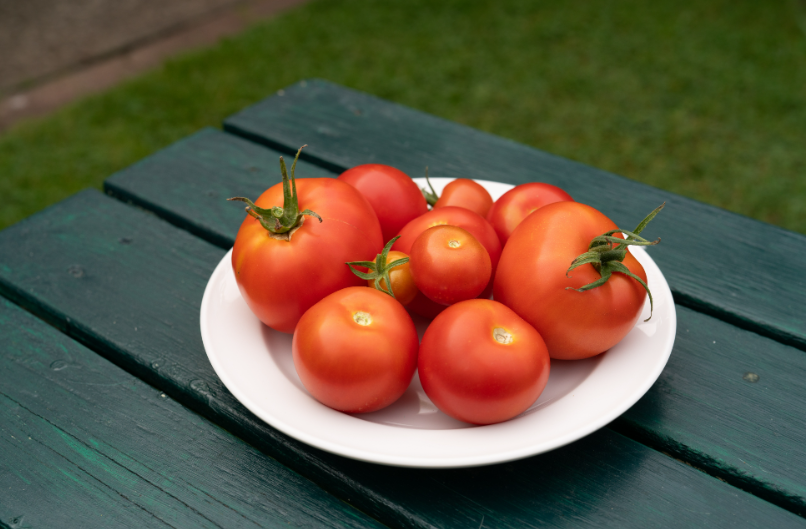 |
|------|------|
|**SfM**||
| Exhaustive | 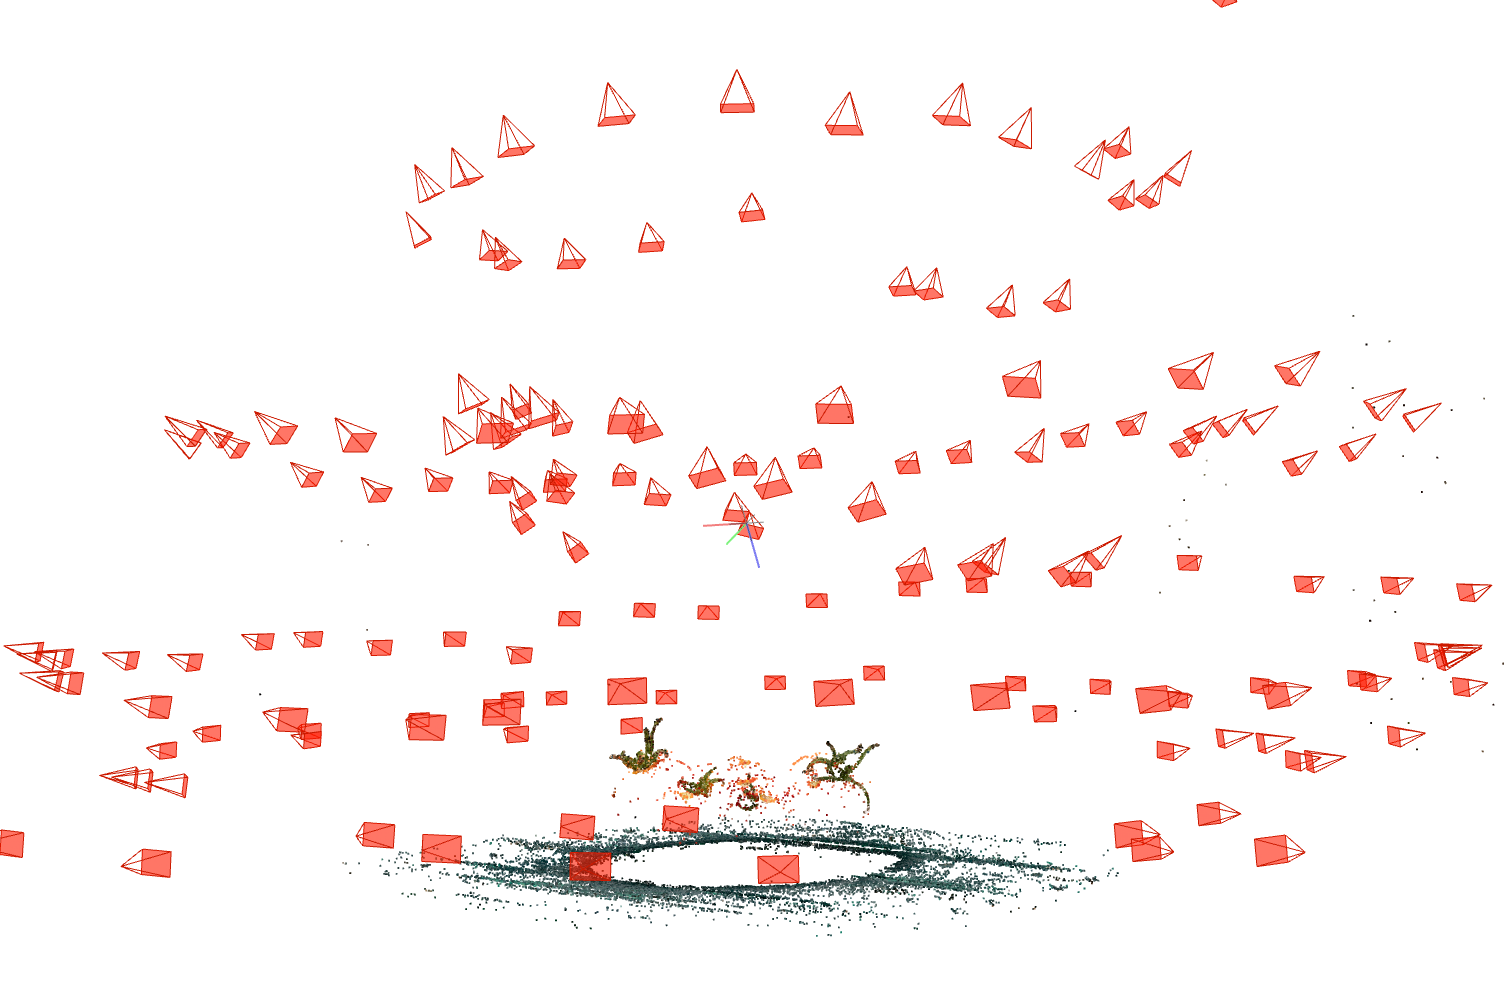|
|Sequiential|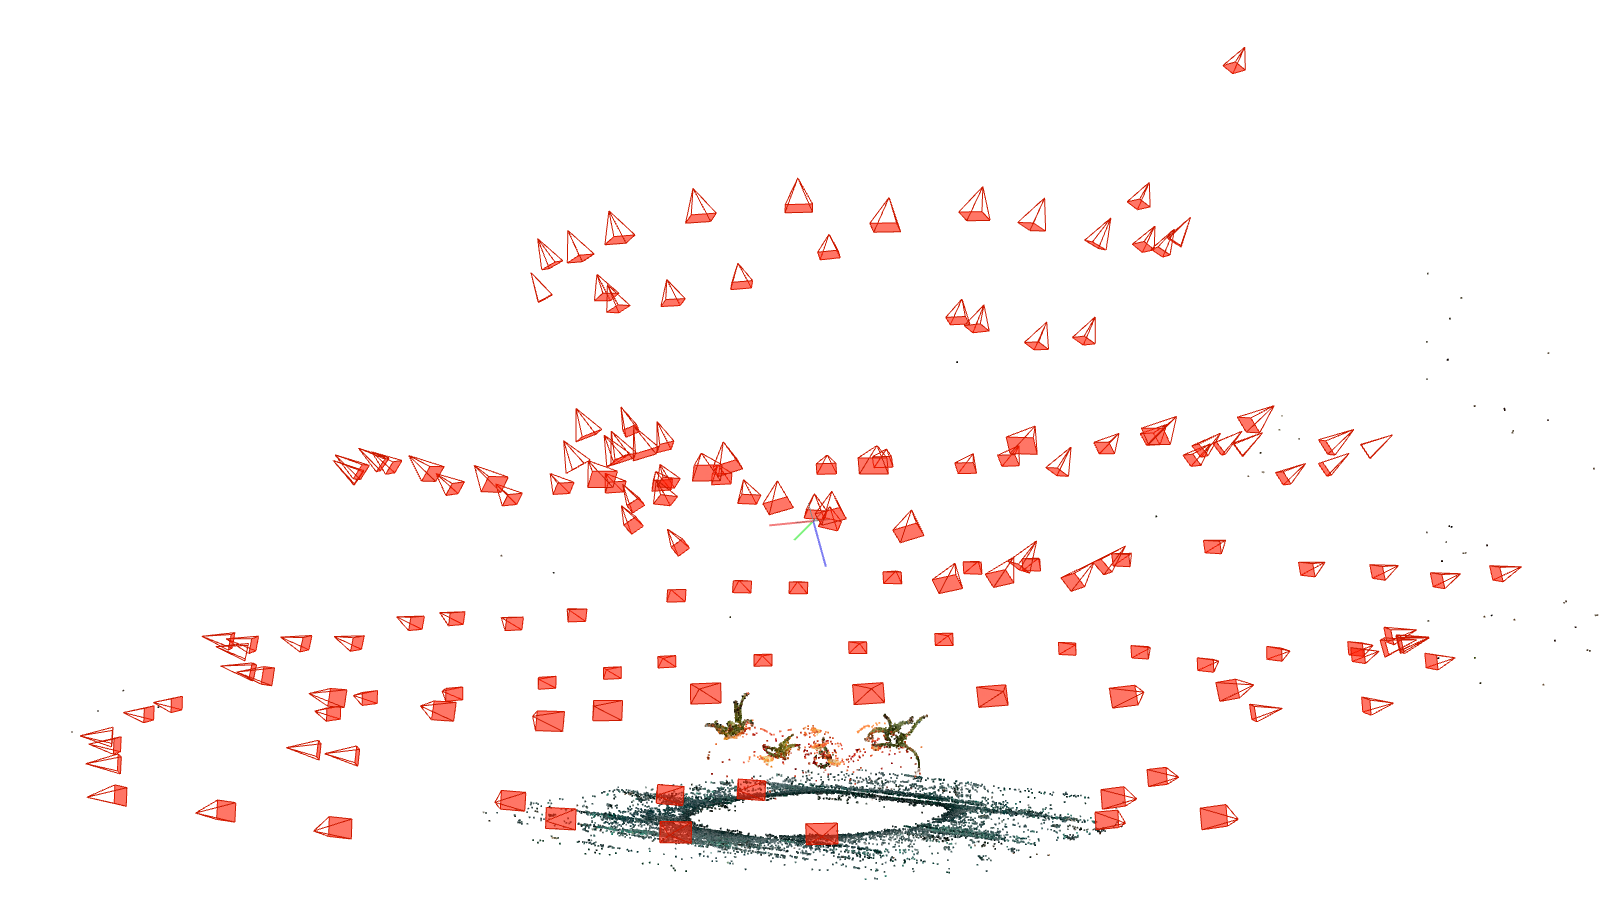|
|Spatian|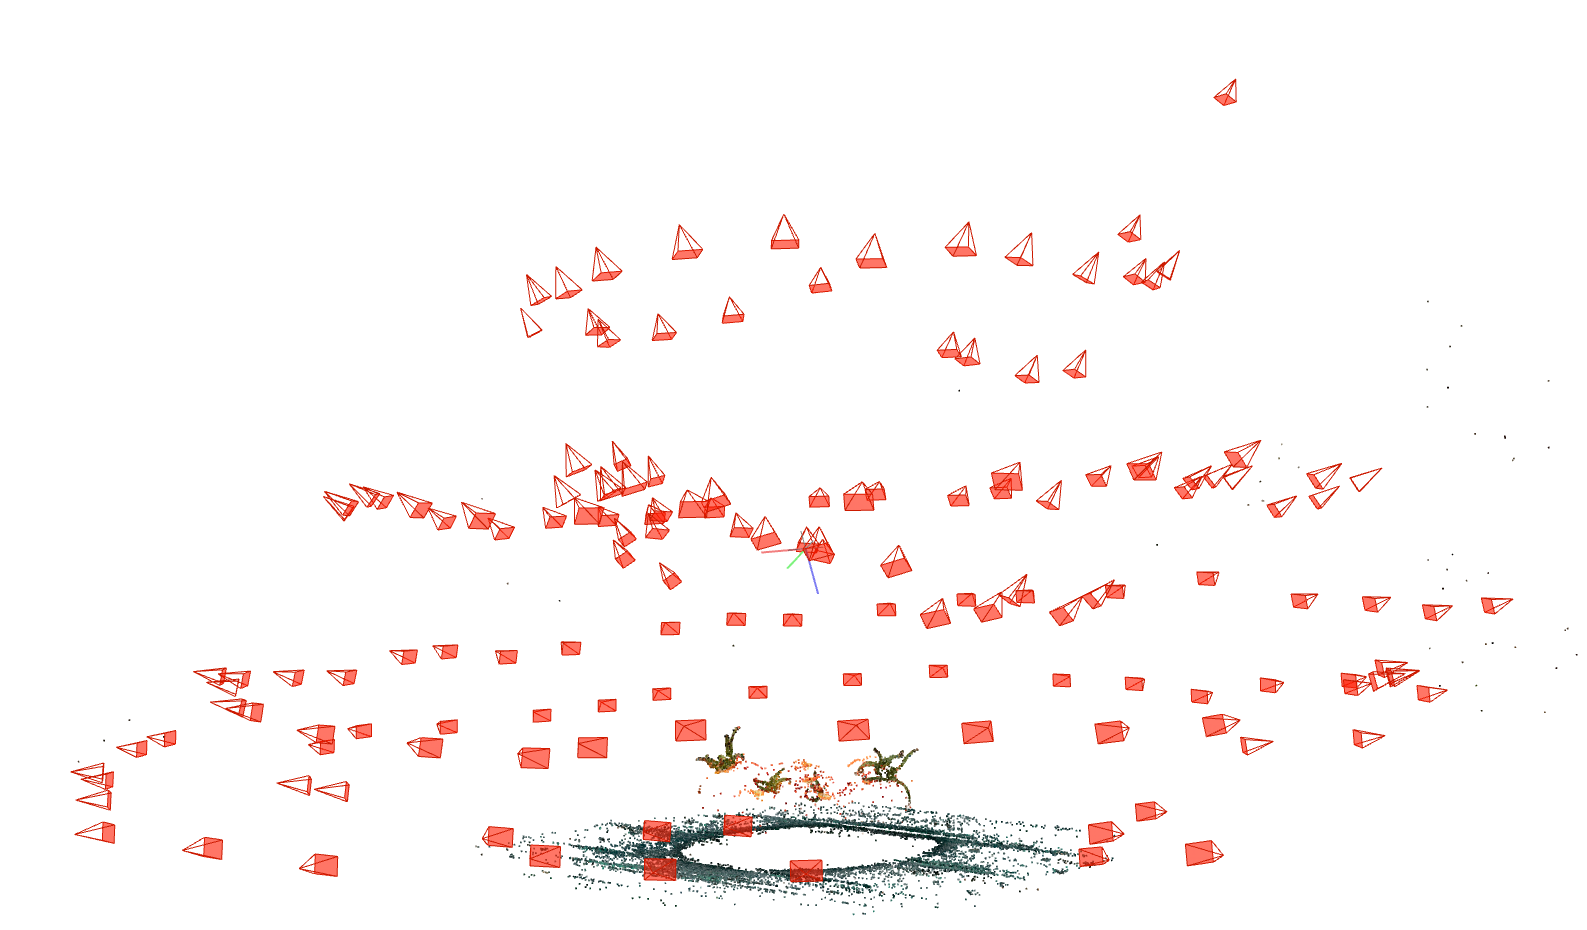|

7. MVS (in cli because i don't have MVS GUI option)
```bash
COLMAP_DATASET_PATH=/path/to/dataset/root

# Undistort Images
colmap image_undistorter \
    --image_path $COLMAP_DATASET_PATH/tomatoes/ \
    --input_path $COLMAP_DATASET_PATH/ \
    --output_path $COLMAP_DATASET_PATH/dense/ \
    --output_type COLMAP

# Patch Match Stereo
colmap patch_match_stereo \
    --workspace_path $COLMAP_DATASET_PATH/dense/ \
    --workspace_format COLMAP \
    --PatchMatchStereo.geom_consistency true

# Stereo Fusion
colmap stereo_fusion \
    --workspace_path $COLMAP_DATASET_PATH/dense/ \
    --workspace_format COLMAP \
    --input_type geometric \
    --output_path $COLMAP_DATASET_PATH/dense/fused.ply

# Create grid (optional)
colmap poisson_mesher \
    --input_path $COLMAP_DATASET_PATH/dense/fused.ply \
    --output_path $COLMAP_DATASET_PATH/dense/meshed-poisson.ply
```

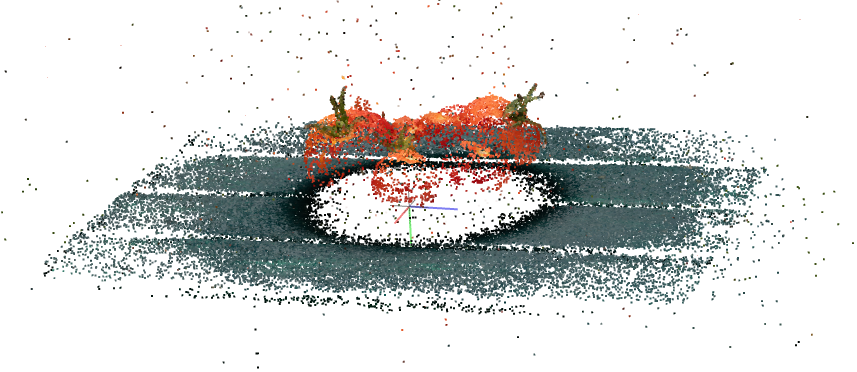